# Calculate and plot the number of exchanged messages over time

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Global variables

In [4]:
pd.set_option("display.precision", 5)
pd.set_option('display.max_rows', 500)

timeframe_upper_limit = 60 # Seconds after startup that you want to look at

### Add path to the dict, use number of nodes as key
It will:
- collect all runs 
- use the key as groupby-column

In [5]:
paths =	{
  #"111": "../../logs/maintenance/25-03-2021",
  "73": "../../logs/movement/29-03-2021"
}

exclude_paths = [
  "movement_run_0",
  "movement_run_1",
  "movement_run_2",
  "movement_run_3",
  "movement_run_4",
  "movement_run_5",
  "movement_run_6",
  "movement_run_7",
  "movement_run_8",
  "movement_run_9"]

num_nodes = 73
height = 2
degree = 8

num_runs = {
  73: 3,
  111: 5
}

In [6]:
# m_xxx = maintenance_xxx
# d_xxx = data_xxx
m_stamps = []
m_topologies = []
m_node_ids = []
m_runs = []

d_stamps = []
d_topologies = []
d_node_ids = []
d_runs = []
d_latencies = []

startup_times = {}

for path in paths : 
    #print(path)
    for root, dirs, files in os.walk(paths[path]) :
        dirs[:] = [directory for directory in dirs if directory not in exclude_paths]
        # print(root)
        # print(dirs)
        # print(files)
        run = root.split('_')[-1]
        for file in files :
            with open( os.path.join(root, file) ) as log :   
                node_id = file.split('_')[0][4:]              
                for line in log :            
                    if "DATA RECEIVED" in line:
                        # data messages
                        elem = line.split( )                
                        d_node_ids.append(int(node_id))                        
                        d_stamps.append( int(elem[8]) ) # unix timestamp
                        d_topologies.append( int(path) )
                        d_runs.append(int(run))
                        d_latencies.append(int(1000000*float(elem[-1])))
                    elif "STARTUP TIME" in line:
                        elem = line.split( )
                        startup_times[int(run)] = int(elem[-1])

d_data = pd.DataFrame(np.column_stack([d_topologies, d_runs, d_node_ids, d_latencies, d_stamps]), 
                        columns=['topology', 'run', 'node_id', 'latency_micros','timestamp'])
# print(startup_time)
d_data

,topology,run,node_id,latency_micros,timestamp
0,73,2,0,2543,1617021190595490773
1,73,2,0,5105,1617021190597745452
2,73,2,0,4265,1617021190597804950
3,73,2,0,4024,1617021190597856918
4,73,2,0,4183,1617021190597906406
...,...,...,...,...,...
20125,73,0,0,1465,1617020613647002206
20126,73,0,0,1497,1617020613647045137
20127,73,0,0,698,1617020613647467730
20128,73,0,0,879,1617020613647926017


In [7]:
d_data['timestamp'] = d_data.apply(lambda row: row.timestamp - startup_times[row.run], axis=1)
d_data['timestamp_sec'] = d_data['timestamp'].apply(lambda x: x // 1000000000)
# d_data

# Reduce timeframe

In [8]:
d_data = d_data[d_data.timestamp_sec <= timeframe_upper_limit]
d_data

,topology,run,node_id,latency_micros,timestamp,timestamp_sec
0,73,2,0,2543,4872501456,4
1,73,2,0,5105,4874756135,4
2,73,2,0,4265,4874815633,4
3,73,2,0,4024,4874867601,4
4,73,2,0,4183,4874917089,4
...,...,...,...,...,...,...
20125,73,0,0,1465,59211116589,59
20126,73,0,0,1497,59211159520,59
20127,73,0,0,698,59211582113,59
20128,73,0,0,879,59212040400,59


# Try to find outliers

In [9]:
d_outliers = d_data.groupby(['topology', 'run', 'node_id', 'timestamp_sec']).size().reset_index(name='number of messages').sort_values(by=['number of messages'], ascending=False, axis=0)
# d_outliers.head()

# Compute results

In [10]:
d_grouped = d_data.groupby(['topology', 'timestamp_sec']).size().reset_index(name='number of messages')
d_grouped['number of messages'] = d_grouped.apply(lambda row: row['number of messages'] / num_runs[row['topology']], axis=1)
d_grouped['number of messages per node'] = d_grouped.apply(lambda row: row['number of messages'] / row['topology'], axis=1)
# d_grouped

# Throughput

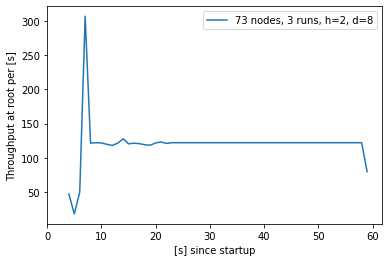

In [11]:
ax = plt.gca()

d_grouped.plot(kind='line',x='timestamp_sec',y='number of messages',ax=ax)

plt.xlabel("[s] since startup")
plt.ylabel("Throughput at root per [s]")

plt.legend([str(num_nodes) +' nodes, ' + str(num_runs[num_nodes]) + ' runs, h=' + str(height) + ', d=' + str(degree)], loc=1)

stepsize=10
ax.xaxis.set_ticks(np.arange(0, timeframe_upper_limit + 1, stepsize))
plt.savefig('movement-throughput-paper.pdf')  

In [12]:
first_30 = d_grouped[d_grouped['timestamp_sec'] <= 30]['number of messages'].sum()
first_60 = d_grouped[d_grouped['timestamp_sec'] <= 60]['number of messages'].sum()
f_30_60 = d_grouped[(d_grouped['timestamp_sec'] >=30) & (d_grouped['timestamp_sec'] < 60)]['number of messages'].sum()

print('Overall exchanged data within first 30s: ' + str(first_30))
print('Overall exchanged data within first 60s: ' + str(first_60))
print('Overall exchanged data between 30s and 60s: ' + str(f_30_60))
print('Exchanged data between 30s and 60s per second per node: ' + str(f_30_60/(30*num_nodes)))

print('\nOverall exchanged maintenance messages during first 30s per node: ' + str(first_30 / num_nodes))

Overall exchanged data within first 30s: 3214.333333333333
Overall exchanged data within first 60s: 6710.0
Overall exchanged data between 30s and 60s: 3617.6666666666665
Exchanged data between 30s and 60s per second per node: 1.6519025875190259

Overall exchanged maintenance messages during first 30s per node: 44.03196347031963


# Latency

In [13]:
d_latency = d_data.groupby(['topology', 'timestamp_sec'],  as_index=False)['latency_micros'].mean()
d_latency['latency_micros'] = d_latency['latency_micros'] / 1000  
d_latency.rename(columns = {'latency_micros':'latency_millis'}, inplace=True)
d_latency.head()

,topology,timestamp_sec,latency_millis
0,73,4,11.74013
1,73,5,34.43494
2,73,6,608.91204
3,73,7,851.31632
4,73,8,1.55334


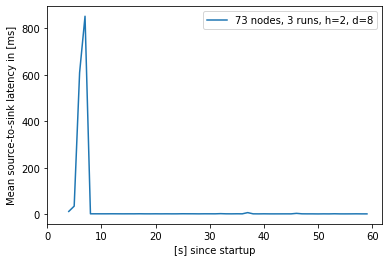

In [14]:
ax = plt.gca()

d_latency.plot(kind='line',x='timestamp_sec',y='latency_millis',ax=ax)

plt.xlabel("[s] since startup")
plt.ylabel("Mean source-to-sink latency in [ms]")

plt.legend([str(num_nodes) +' nodes, ' + str(num_runs[num_nodes]) + ' runs, h=' + str(height) + ', d=' + str(degree)], loc=1)

stepsize=10
ax.xaxis.set_ticks(np.arange(0, timeframe_upper_limit + 1, stepsize))
plt.savefig('movement-latency-paper.pdf')  